We want to determine if the theory we have so far can be used to calculate the vacuum Rabi splitting.  From testing, it seems that we aren't going to be able to obtain analytical solutions for the 3 and 4 level cases, so we'll just focus on numerical ones for now

## Imports

In [1]:
import sympy as sym
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt
import itertools as it

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def von_Neumann_rhs(ρ, H):
    return -1j* (H @ ρ - ρ @ H)

## 2 Level Calculation
We'll start by considering the simpler 2 level system and checking if we can replicate the well-known results.  We'll consider only a single atom for now and use the basis $\{|n\rangle, |n+1\rangle\}$ for the cavity mode.

In [4]:
# Define the parameters
ωc = 10
ω2 = 85
ω1 = 75
g21 = 10
m = 1

In [5]:
# Define the Hamiltonian
H = np.array([[ωc * (m-1) + ω2, g21 * np.sqrt(m)], [g21 * np.sqrt(m), ωc * m + ω1]])
print(H)

[[85. 10.]
 [10. 85.]]


In [6]:
# Let's do von Neumann evolution - we'll just use a random ωc value for now
ρ0 = np.array([[0, 0], [0, 1]])
ρ_list = []
ρ_curr = ρ0.copy()
num_steps = 100
ts, dt = np.linspace(0, 1, num_steps, retstep=True)
for i in range(ts.shape[0]):
    ρ_list.append(ρ_curr)
    ρ_next = ρ_curr + dt * von_Neumann_rhs(ρ_curr, H)
    ρ_next /= np.trace(ρ_next)
    ρ_curr = ρ_next

Actually, we need to think a bit more about what we want to show here.  We want to see vacuum rabi oscillations, so we need to look at the time evolution of the system under the Hamiltonian, but we're also probably going to want to see how the relative frequency differences impact that too.

In [7]:
ρ_list[2]

array([[0.02040608+0.j       , 0.        -0.2020202j],
       [0.        +0.2020202j, 0.97959392+0.j       ]])

In [8]:
# Get the excited and ground state populations
ρ_g = np.zeros(ts.shape[0])
ρ_e = np.zeros(ts.shape[0])
for i in range(ts.shape[0]):
    ρ_g[i] = ρ_list[i][1][1]
    ρ_e[i] = ρ_list[i][0][0]

/tmp/ipykernel_7631/1425826990.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  ρ_g[i] = ρ_list[i][1][1]
/tmp/ipykernel_7631/1425826990.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  ρ_e[i] = ρ_list[i][0][0]


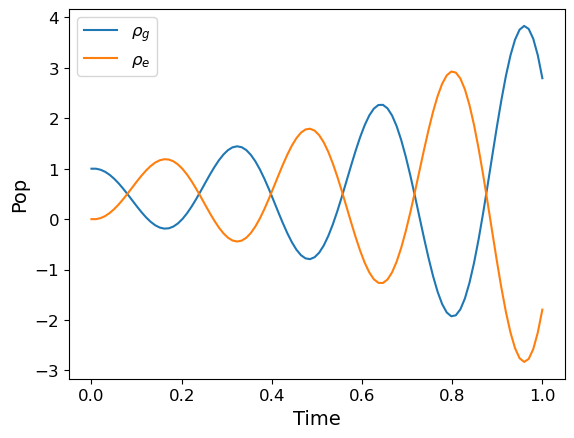

In [9]:
plt.plot(ts, ρ_g, label='$\\rho_g$')
plt.plot(ts, ρ_e, label='$\\rho_e$')
plt.xlabel("Time")
plt.ylabel("Pop")
plt.legend()

In [10]:
# Try using wavefunction approach instead
ψ_gr = np.array([0, 1])
ψ_ex = np.array([1, 0])
prob_exc_list = []
prob_gro_list = []
for i in range(ts.shape[0]):
    ψ_evol = linalg.expm(-1j * H * ts[i]) @ ψ_gr
    #ψ_evol /= np.abs(ψ_evol.conj().T @ ψ_evol) ** 2
    prob_exc_list.append(np.abs(ψ_ex.conj().T @ ψ_evol) ** 2)
    prob_gro_list.append(np.abs(ψ_gr.conj().T @ ψ_evol) ** 2)

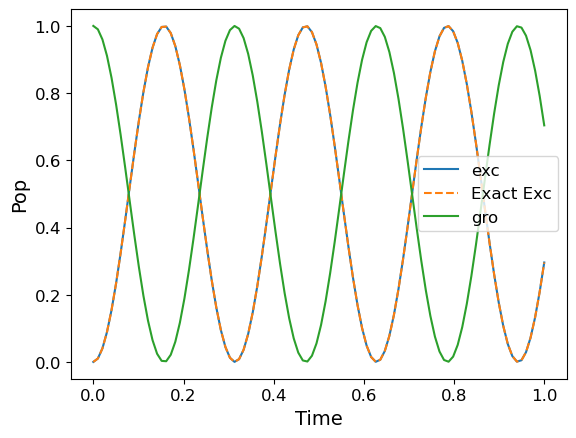

In [11]:
plt.plot(ts, prob_exc_list, label='exc')
plt.plot(ts, np.sin(g21 * ts) ** 2, '--', label='Exact Exc')
plt.plot(ts, prob_gro_list, label='gro')
plt.xlabel("Time")
plt.ylabel("Pop")
plt.legend()

So this is what the vacuum oscillations should look like for a system on resonance with a max of 1 photon according to the Jaynes-Cummings wikipedia article.  I'm not sure how to get the von Neumann evolution of the density matrix to not start exploding.  It's always maintaining the $\rho_{00} + \rho_{11} = 1$ condition, but not the positivity condition.  It should be possible to do that in qutip or something though.

## 3 Level case

In [12]:
# Define additional parameters
ωi = 50
g1i = 12.5

In [13]:
# Define Hamiltonian
H = np.array([[ωc * (m-1) + ω2, g21 * np.sqrt(m), 0],
              [g21 * np.sqrt(m), ωc * m + ω1, g1i],
              [0, g1i, ωc * m + ωi]])

In [14]:
# Define vectors for energy levels
ψ_i = np.array([0, 0, 1])
ψ_1 = np.array([0, 1, 0])
ψ_2 = np.array([1, 0, 0])

In [15]:
# Define lists for state evolution
p2 = np.zeros(ts.shape[0])
p1 = np.zeros(ts.shape[0])
pi = np.zeros(ts.shape[0])

# Evolve assuming we start in pi
for i in range(ts.shape[0]):
    ψ_evol = linalg.expm(-1j * H * ts[i]) @ ψ_i
    p2[i] = np.abs(ψ_2.conj().T @ ψ_evol) ** 2
    p1[i] = np.abs(ψ_1.conj().T @ ψ_evol) ** 2
    pi[i] = np.abs(ψ_i.conj().T @ ψ_evol) ** 2 

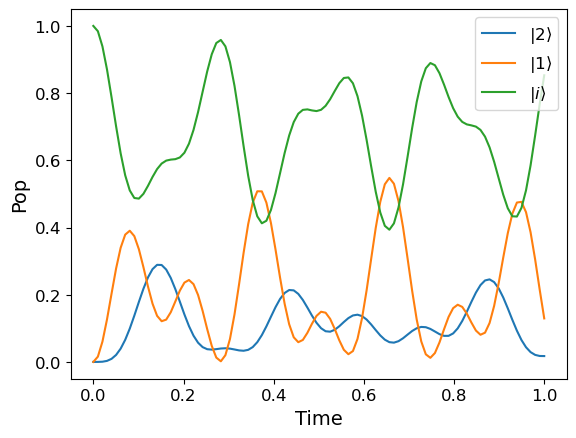

In [16]:
plt.plot(ts, p2, label='$|2\\rangle$')
plt.plot(ts, p1, label='$|1\\rangle$')
plt.plot(ts, pi, label='$|i\\rangle$')
plt.xlabel("Time")
plt.ylabel("Pop")
plt.legend()

## 4 Level case

In [27]:
# Define parameters
ωg = 0
gig = 50

In [28]:
# Define Hamiltonian
H = np.array([[ωc * (m-1) + ω2, g21 * np.sqrt(m), 0, 0],
              [g21 * np.sqrt(m), ωc * m + ω1, g1i, 0],
              [0, g1i, ωc * m + ωi, gig],
              [0, 0, gig, ωc * m + ωg]])

In [29]:
# Define vectors for energy levels
ψ_g = np.array([0, 0, 0, 1])
ψ_i = np.array([0, 0, 1, 0])
ψ_1 = np.array([0, 1, 0, 0])
ψ_2 = np.array([1, 0, 0, 0])

In [30]:
# Define lists for state evolution
p2 = np.zeros(ts.shape[0])
p1 = np.zeros(ts.shape[0])
pi = np.zeros(ts.shape[0])
pg = np.zeros(ts.shape[0])

# Evolve assuming we start in pi
ψ_init = ψ_g.copy()
for i in range(ts.shape[0]):
    ψ_evol = linalg.expm(-1j * H * ts[i]) @ ψ_init
    p2[i] = np.abs(ψ_2.conj().T @ ψ_evol) ** 2
    p1[i] = np.abs(ψ_1.conj().T @ ψ_evol) ** 2
    pi[i] = np.abs(ψ_i.conj().T @ ψ_evol) ** 2 
    pg[i] = np.abs(ψ_g.conj().T @ ψ_evol) ** 2

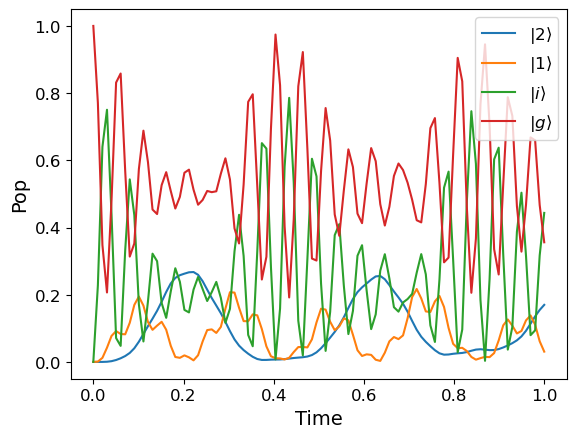

In [31]:
plt.plot(ts, p2, label='$|2\\rangle$')
plt.plot(ts, p1, label='$|1\\rangle$')
plt.plot(ts, pi, label='$|i\\rangle$')
plt.plot(ts, pg, label='$|g\\rangle$')
plt.xlabel("Time")
plt.ylabel("Pop")
plt.legend()